# <span style="font-size:32px; font-weight:bold;"> Hybrid Deep Learning Model for AI vs Human Text Classification</span>


## <span style="font-size:20px; font-weight:bold;"> Import Libraries and Setup</span>


In [1]:
import random, numpy as np, pandas as pd, os, shutil, re
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import tensorflow_text as tf_text
import kagglehub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Bidirectional, LSTM, Dropout,
                                     Conv1D, GlobalMaxPooling1D, Dense, LayerNormalization,
                                     MultiHeadAttention, Layer)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2025-05-21 18:07:08.089760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747850828.514343      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747850828.634353      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Set seeds for reproducibility

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

## Download and Load Dataset

In [3]:
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")
df = pd.read_csv(f"{path}/AI_Human.csv").head(100000)
df = df.rename(columns={"generated": "label"})
df["label"] = df["label"].astype(int)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=seed)
train_df["prompt_id"] = 0  
test_df["prompt_id"] = 0

## Visualize Label Distribution

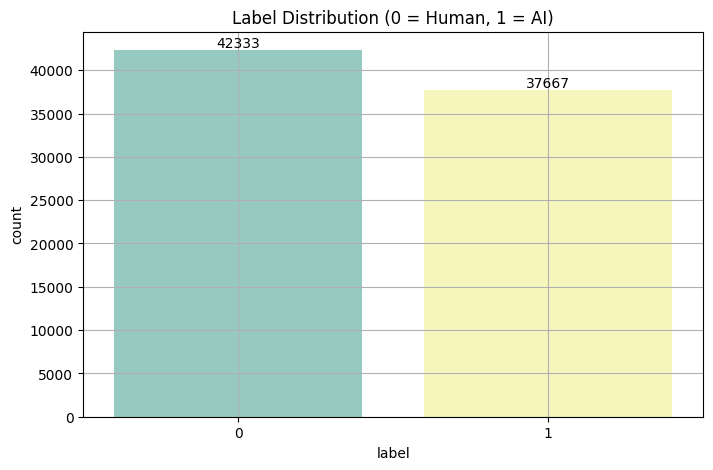

In [4]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=train_df, x="label", palette='Set3')
abs_values = train_df['label'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('Label Distribution (0 = Human, 1 = AI)')
plt.grid(True)
plt.show()

## Text Cleaning Functions

In [5]:

def tf_clean(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?¡¿]', '')
    text = tf.strings.regex_replace(text, '[.?!¿¡]', r'\0 ')
    text = tf.strings.strip(text)
    text = tf.strings.regex_replace(text, '\.\.\.', ' ')
    text = tf.strings.join([' ', text, ' '], separator=' ')
    return text

def clean_text(text):
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()


## Apply Text Cleaning

In [6]:
train_df["text"] = train_df["text"].apply(clean_text)
test_df["text"] = test_df["text"].apply(clean_text)

## Tokenization and Padding

In [7]:
max_features = 20000
sequence_length = 128

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_df["text"])

X_train = tokenizer.texts_to_sequences(train_df["text"])
X_test = tokenizer.texts_to_sequences(test_df["text"])

X_train = pad_sequences(X_train, maxlen=sequence_length)
X_test = pad_sequences(X_test, maxlen=sequence_length)

y_train = train_df["label"].values
y_test = test_df["label"].values

## Define Transformer Block

In [8]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

## Build Model

In [9]:
embedding_dim = 128

inputs = Input(shape=(sequence_length,), dtype="int64")
x = Embedding(max_features, embedding_dim)(inputs)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = TransformerBlock(embed_dim=128, num_heads=2, ff_dim=32)(x)
x = Conv1D(128, kernel_size=5, activation="relu")(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

I0000 00:00:1747850960.030365      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747850960.031047      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 128, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 128, 128)            │         140,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 124, 128)            │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,898,337 (11.06 MB)

 Trainable params: 2,898,337 (11.06 MB)

 Non-trainable params: 0 (0.00 B)

## Extracting the embedding layer from the model:

In [10]:
import tensorflow as tf
import numpy as np

embedding_layer = model.layers[1]  

embedding_model = tf.keras.Model(inputs=model.input, outputs=embedding_layer.output)

sample_input = X_test[1:2]  

embeddings = embedding_model.predict(sample_input)
print("Embedding shape:", embeddings.shape)  

for i, vector in enumerate(embeddings[0][:3]):
    print(f"Token {i+1} embedding:\n{vector}\n")

I0000 00:00:1747850969.389248      97 service.cc:148] XLA service 0x57be9870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747850969.390646      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747850969.390664      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747850969.456473      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Embedding shape: (1, 128, 128)
Token 1 embedding:
[ 0.01871404 -0.033463   -0.02841036 -0.00253775  0.04315018 -0.04778355
 -0.002907    0.00411784 -0.00663285 -0.01341796  0.03044344 -0.04020373
  0.03633     0.03501664  0.01583438  0.0216809   0.00022955 -0.00900149
 -0.03815302  0.03203194 -0.04406178  0.04728767 -0.04703963 -0.02325645
 -0.01136339 -0.03886116  0.01576113  0.03002698  0.00697917  0.03237626
  0.02537031 -0.03990679  0.04321594 -0.04292964  0.02842403 -0.01340419
  0.01723666  0.01664405  0.03989572  0.04025172  0.04557857 -0.00064152
 -0.02636536  0.03649796  0.00992782  0.00672371 -0.01311423  0.03629676
 -0.01306716  0.04075969  0.01376612  0.02741044 -0.02986308 -0.00145578
 -0.00501481  0.00033699  0.01128431  0.03305801 -0.02011004 -0.01479363
  0.0490896   0.01281425 -0.00786148 -0.00298849  0.01732047 -0.02969828
 -0.0466174  -0.01080959  0.00017177 -0.0027029   0.01242337 -0.0062489
 -0.0123528  -0.0292271  -0.04819915

I0000 00:00:1747850969.629343      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


## Train Model

In [11]:
checkpoint_cb = ModelCheckpoint("model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=4, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_schedule]
)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 27ms/step - accuracy: 0.9103 - loss: 0.2075 - val_accuracy: 0.9887 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.9894 - loss: 0.0359 - val_accuracy: 0.9882 - val_loss: 0.0421 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.9932 - loss: 0.0230 - val_accuracy: 0.9893 - val_loss: 0.0374 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.9933 - loss: 0.0218 - val_accuracy: 0.9908 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9955 - loss: 0.0144
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.9955 - loss: 0.0144 - val_accuracy: 0.9905 - val_loss: 0.0578 - learning_rate: 0.0010
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy

## Evaluate Model

✅ Test Accuracy: 98.93%
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


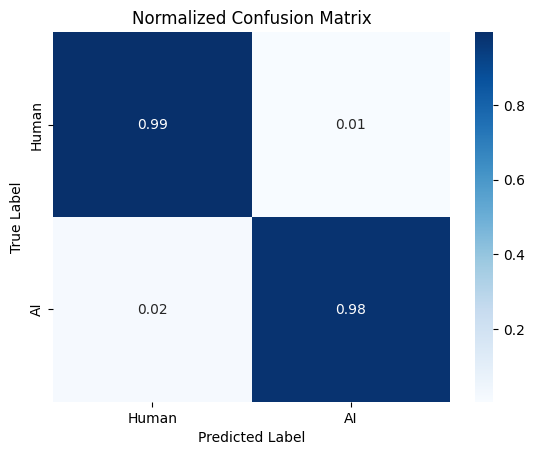


Classification Report:
              precision    recall  f1-score   support

       Human       0.99      0.99      0.99     10583
          AI       0.99      0.98      0.99      9417

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Human', 'AI']))

## Plot Accuracy and Loss Curves

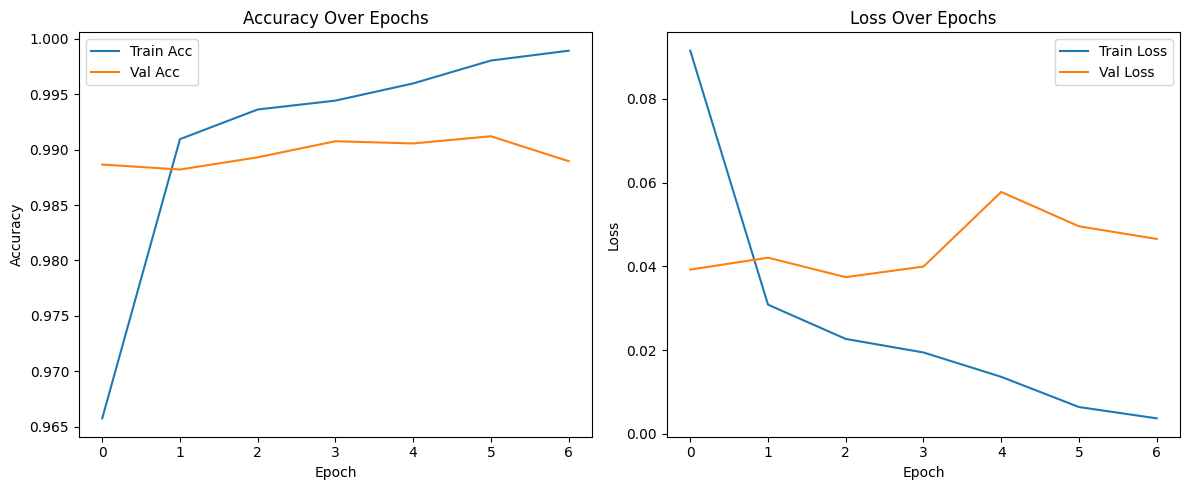

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## ROC Curve and AUC

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


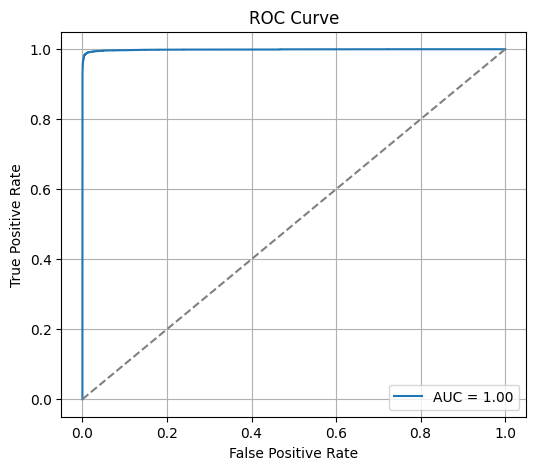

In [15]:
y_scores = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc_score = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

 ## Export Predictions to CSV

In [16]:
predictions_df = pd.DataFrame({
    "Text": test_df["text"],
    "True_Label": y_test,
    "Predicted_Label": y_pred.flatten(),
    "Confidence_Score": y_pred_probs.flatten()
})
predictions_df.to_csv("predictions_output.csv", index=False)
print("✅ Saved predictions to predictions_output.csv")

✅ Saved predictions to predictions_output.csv


In [16]:
predictions_df.head()

,Text,True_Label,Predicted_Label,Confidence_Score
51394,to the fellow citizens using cars its very eas...,0,0,0.000863
79088,while humans express themselves through speech...,1,1,1.000000
46230,the challenge of exploring venus is an article...,1,1,0.999994
64829,driverless cars both have good and bad aspects...,0,0,0.006368
39558,minimum wage is a very important topic that af...,1,1,0.999999
